# Experiments with the diversity condition violated

In this notebook I will perform the SimCLR experiments where the diversity condition was violated. Mathematically it essentially means that we will use the following distributions for sampling:

- $p(z) = \frac{1}{|\mathcal{Z}|}$ - Marginal distribution is simply a uniform distribution on a sphere
- $p(\tilde{z}|z) = \delta(u-u') \frac{e^{\kappa \tilde{z}^{T}z}}{\int_{W}e^{\kappa v^{T}v' dv}}$

Where the latent space can be decomposed into 2 components $z = (u,v)^{T}$ where $u \in R^{n}$, $v \in R^{m}$, and $m + n = d$ - the dimension of the latent space.

I will primarily work with hyper-spheres as my latent space, hence the condition $z^{2} = u^{2} + v^{2} = 1$ will be enforced.

Experiment with these data-generating processes:

- Identity ✅
- Linear Mapping (to 4D, 5D, 6D, 7D) ✅
- Spirals ✅
- Patches ✅
- Injective Neural Network as a data generating process ✅

For now fix one dimension (the first one):

Consider later:

- Fix multiple dimensions
- Fix dimensions randomly


Additionally, we want to take an orthogonal transformation and check that the loss in our sampling experiment is higher than the loss we have achieved by directly optimizing the neural network $f$

In [3]:
%load_ext autoreload
%autoreload 2
    
import torch
from torch import nn
from torch import functional
from simclr.simclr import SimCLR
from encoders import get_mlp
import matplotlib.pyplot as plt
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 6144
tau = 0.3
kappa = 1 / tau
iterations = 10000
latent_dim = 3

fixed_dims_on_sample = 1

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:,:u_dim]
    v = z[:,u_dim:]

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch) * torch.norm(v, p=2, dim=-1, keepdim=True)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch) # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)
    
sample_uniform_fixed = lambda batch: full_sphere.uniform(batch)
sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, fixed_dims_on_sample)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualizing the constrained sampling procedure

Below you can see how samples from the constrained sampling distribution look like

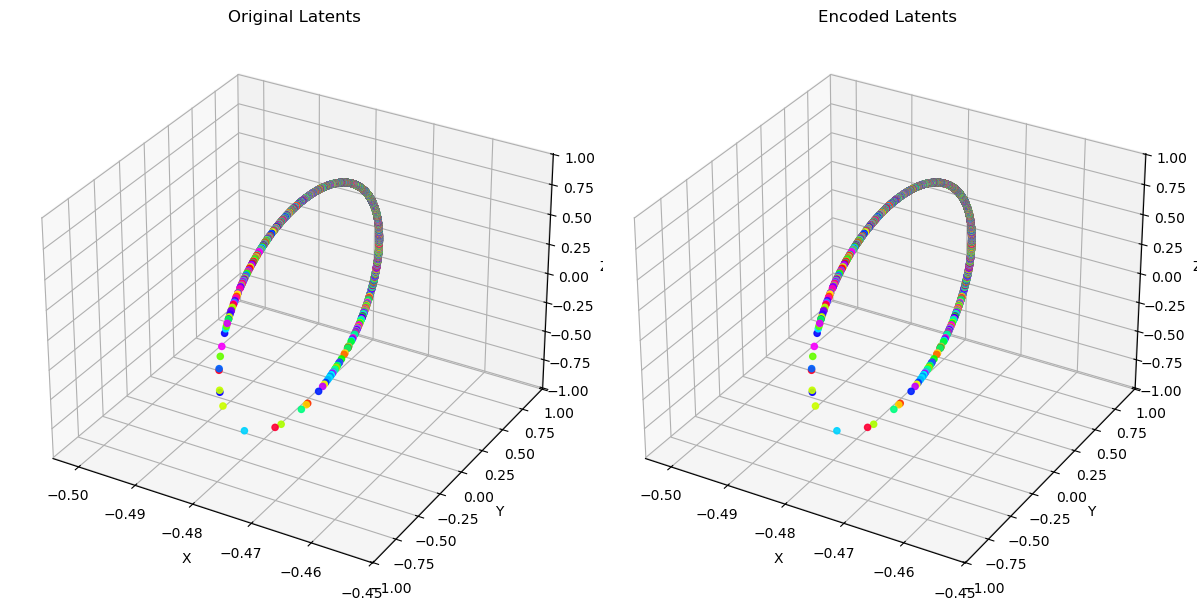

In [4]:
z = sample_uniform_fixed(1).squeeze(0)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch_size) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(batch_size, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

## Training the identity generating process

$g(z) = z$

In [5]:
from visualization_utils.scoring import plot_scores
from visualization_utils.spheres import scatter3d_sphere

class LinearEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return torch.nn.functional.normalize(self.fc(x), dim=-1, p=2)


f_constrained = LinearEncoder(3, 3)

g_id = nn.Identity()

simclr_id = SimCLR(
    f_constrained, g_id, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_constrained, scores = simclr_id.train(batch_size, iterations)

plot_scores(plt, scores)

h_constrained = lambda z: f_constrained(g_id(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_constrained(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.899693489074707 Samples processed: 1 linear disentanglement: 0.7416579127311707 permutation disentanglement: 0.1790267825126648 angle_preservation_error: 0.29266929626464844
Loss: 7.889121055603027 Samples processed: 21 linear disentanglement: 0.7556570172309875 permutation disentanglement: 0.1804821491241455 angle_preservation_error: 0.29026442766189575
Loss: 7.887140274047852 Samples processed: 41 linear disentanglement: 0.7523940205574036 permutation disentanglement: 0.18905693292617798 angle_preservation_error: 0.2887357473373413


KeyboardInterrupt: 

In [6]:
def compute_orthogonal_transformation_loss(sample_joint, sample_marginal):
    z, z_aug = sample_joint(batch_size)

    # (N, N, 3)
    z_neg = torch.nn.functional.normalize(
        torch.randn((batch_size, batch_size, latent_dim), device=z.device), p=2, dim=-1)

    pos = - torch.sum(z * z_aug, dim=-1).mean() / tau
    
    # (N, 1, 3) * (N, N, 3) -> (N, N, 3)
    neg = torch.log(torch.exp((z.unsqueeze(1) * z_neg).sum(dim=-1) / tau).sum(-1)).mean()

    return (pos + neg).item()


orthogonal_loss = compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed)
training_loss = 7.183150291442871 # TODO: just for testing now

print("Orthogonal transformation loss: ", orthogonal_loss)
print("Training loss: ", scores['eval_losses'[-1]])


Orthogonal transformation loss:  7.198638439178467


NameError: name 'scores' is not defined

## Linear map generating process

$g(z) = Az$, where $A \in \mathbb{R}^{k \times 3}$ and $k \in \{4,5,6,7\}$ and $rank(A) = 3$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.070331573486328 Samples processed: 1 linear disentanglement: 0.5869646668434143 permutation disentanglement: 0.06386673450469971 angle_preservation_error: 0.30578935146331787
Loss: 8.076375007629395 Samples processed: 21 linear disentanglement: 0.5787732005119324 permutation disentanglement: 0.060732126235961914 angle_preservation_error: 0.30550506711006165
Loss: 8.05259895324707 Samples processed: 41 linear disentanglement: 0.5910077691078186 permutation disentanglement: 0.06354590505361557 angle_preservation_error: 0.3007197082042694
Loss: 8.048955917358398 Samples processed: 61 linear disentanglement: 0.5871803164482117 permutation disentanglement: 0.062345486134290695 angle_preservation_error: 0.2991761863231659
Loss: 8.012823104858398 Samples processed: 81 linear disentanglement: 0.5957269072532654 permutation disentanglement: 0.07040967792272568 angle_preservation_error: 0.29295408725738525
Loss: 8.002143859863281 S

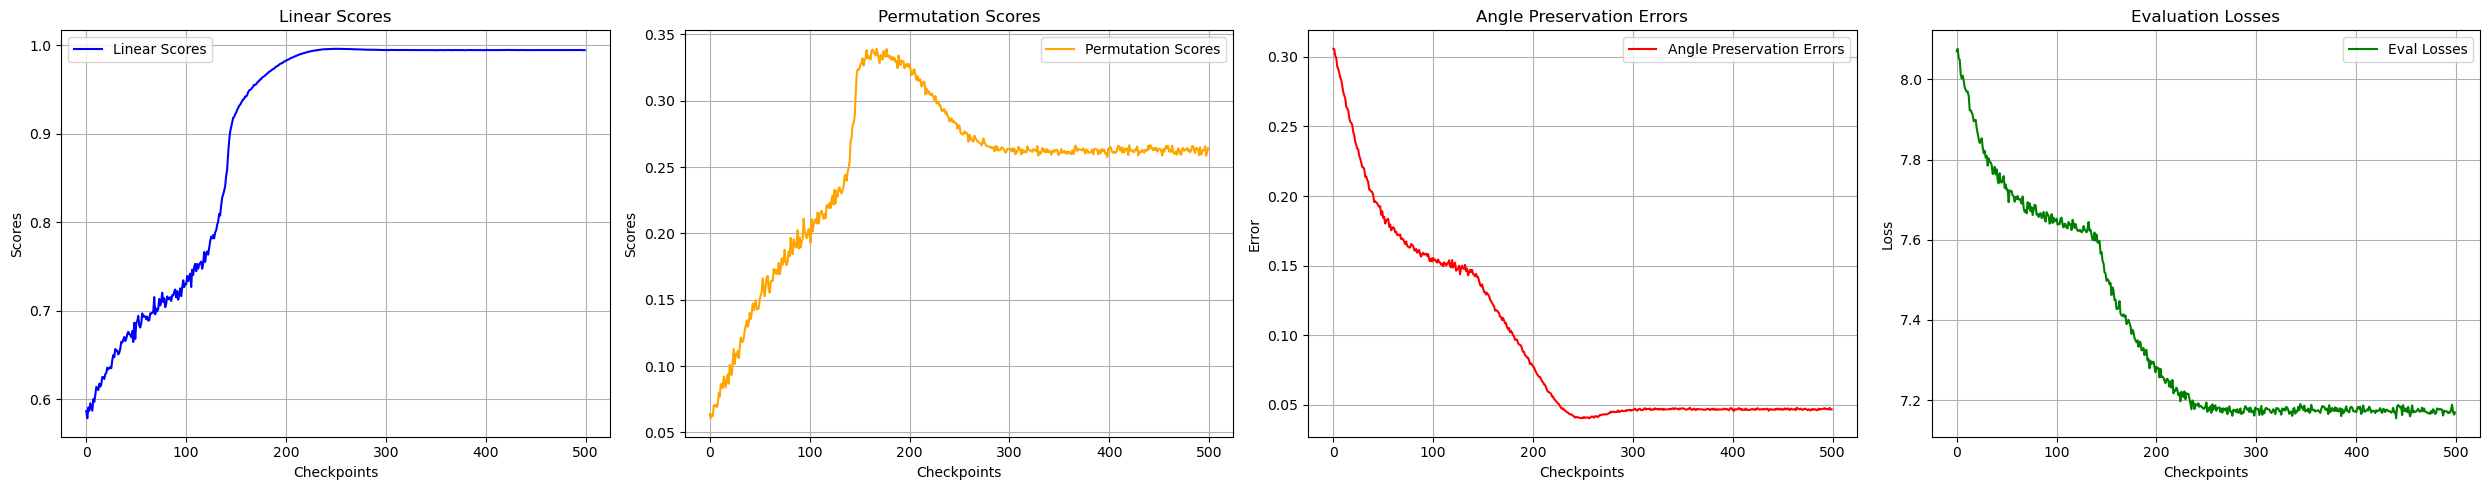

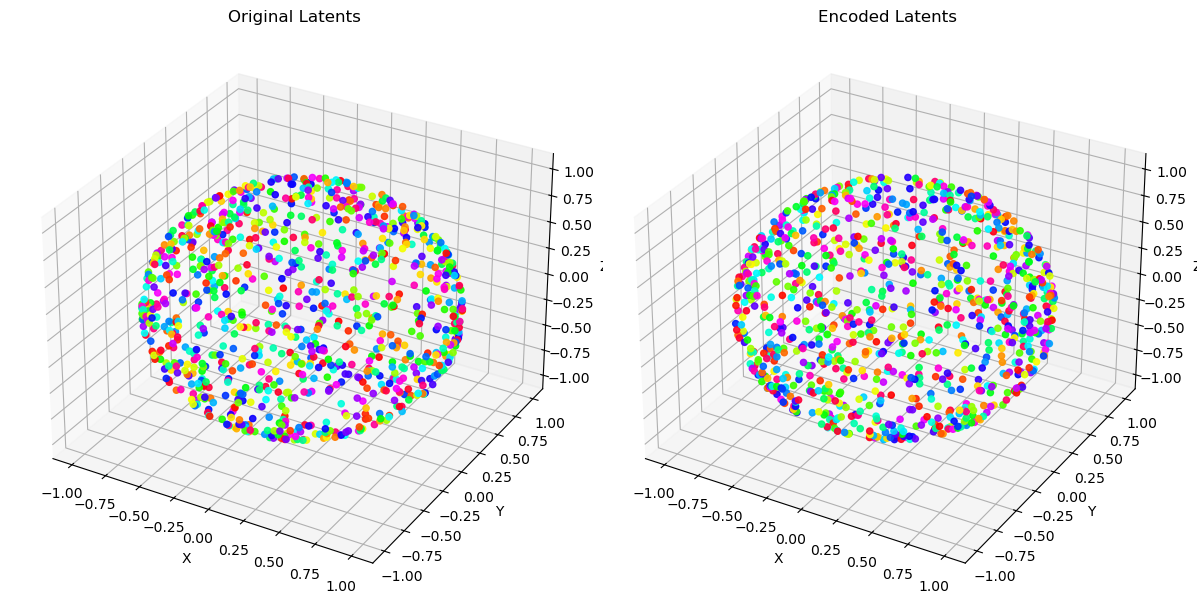

In [10]:
from experiment_utils.linear import perform_linear_experiment

f_linear_constrained = LinearEncoder(4, 3)

h, scores = perform_linear_experiment(
    4, 10000, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f_linear_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [11]:
print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed))
print("Training loss", scores['eval_losses'][-1])


Orhtogonal loss: 7.200047492980957
Training loss 7.169550895690918


Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.7966132164001465 Samples processed: 1 linear disentanglement: 0.507245659828186 permutation disentanglement: 0.009771406650543213 angle_preservation_error: 0.2175920158624649
Loss: 7.221581935882568 Samples processed: 21 linear disentanglement: 0.8972740173339844 permutation disentanglement: 0.08629745244979858 angle_preservation_error: 0.10872795432806015
Loss: 7.193445205688477 Samples processed: 41 linear disentanglement: 0.9509172439575195 permutation disentanglement: 0.05718042328953743 angle_preservation_error: 0.07640194892883301
Loss: 7.184333801269531 Samples processed: 61 linear disentanglement: 0.9599338173866272 permutation disentanglement: 0.06089631840586662 angle_preservation_error: 0.07260969281196594
Loss: 7.174376487731934 Samples processed: 81 linear disentanglement: 0.9605202674865723 permutation disentanglement: 0.06209339573979378 angle_preservation_error: 0.0710691511631012
Loss: 7.182978630065918 S

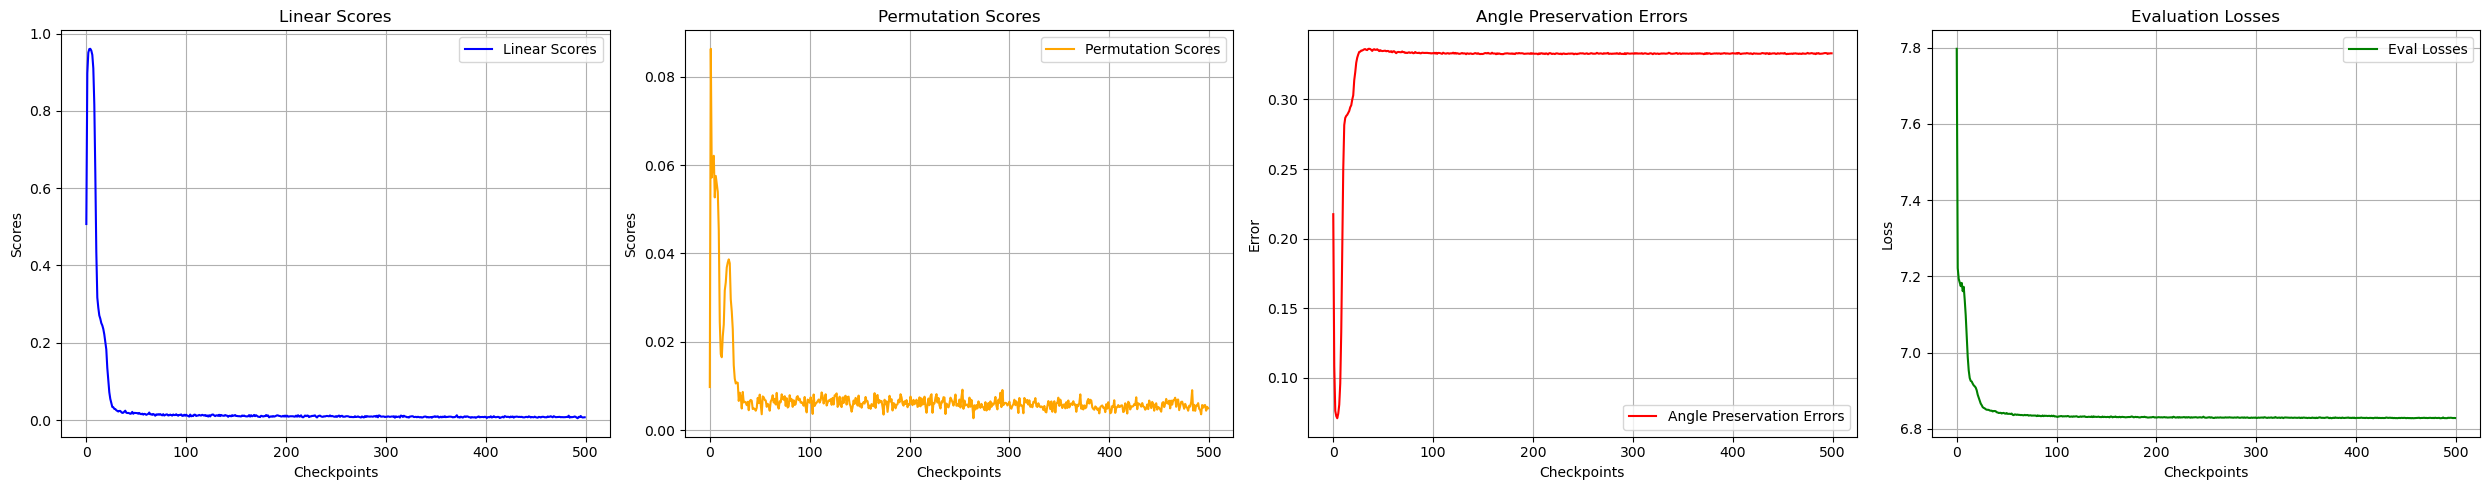

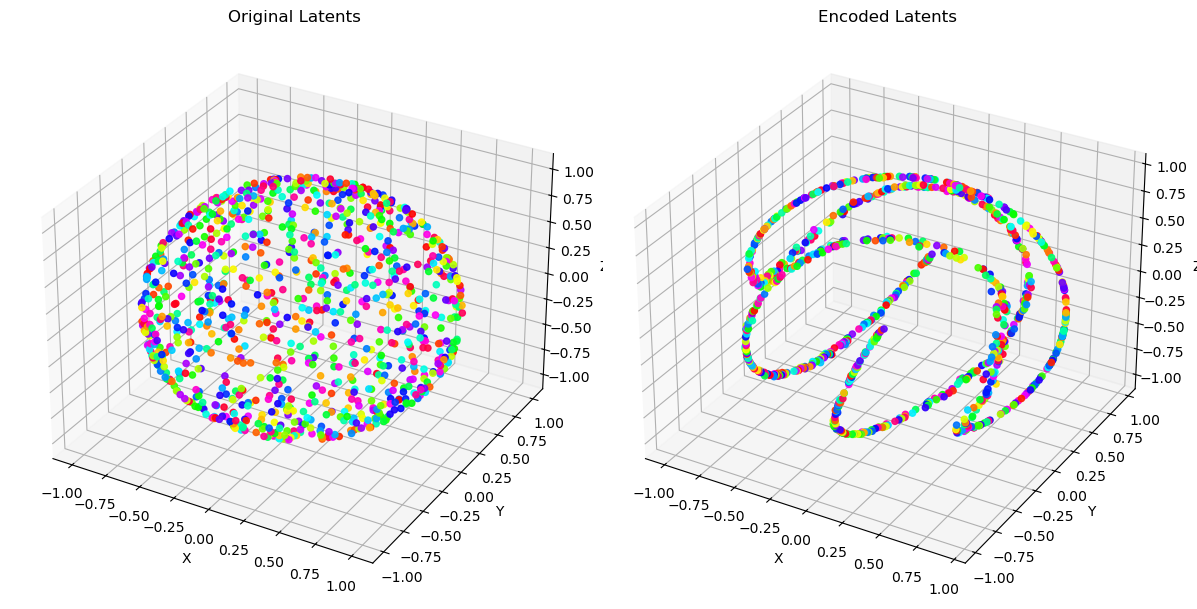

Orhtogonal loss: 7.1967644691467285
Training loss 6.828713893890381


In [12]:
from encoders import SphericalEncoder
from experiment_utils.linear import perform_linear_experiment

f_constrained = SphericalEncoder(input_dim=4, output_dim=3)

h, scores = perform_linear_experiment(
    4, 10000, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed))
print("Training loss", scores['eval_losses'][-1])

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.189489364624023 Samples processed: 1 linear disentanglement: 0.6390101313591003 permutation disentanglement: 0.13531140983104706 angle_preservation_error: 0.33495497703552246
Loss: 8.188491821289062 Samples processed: 21 linear disentanglement: 0.6300413608551025 permutation disentanglement: 0.1347329020500183 angle_preservation_error: 0.3331667184829712
Loss: 8.171136856079102 Samples processed: 41 linear disentanglement: 0.633979856967926 permutation disentanglement: 0.1415959745645523 angle_preservation_error: 0.32558488845825195
Loss: 8.16207504272461 Samples processed: 61 linear disentanglement: 0.6392166018486023 permutation disentanglement: 0.15010564029216766 angle_preservation_error: 0.3235483467578888
Loss: 8.1572265625 Samples processed: 81 linear disentanglement: 0.6281382441520691 permutation disentanglement: 0.1471719592809677 angle_preservation_error: 0.32217276096343994
Loss: 8.150237083435059 Samples proc

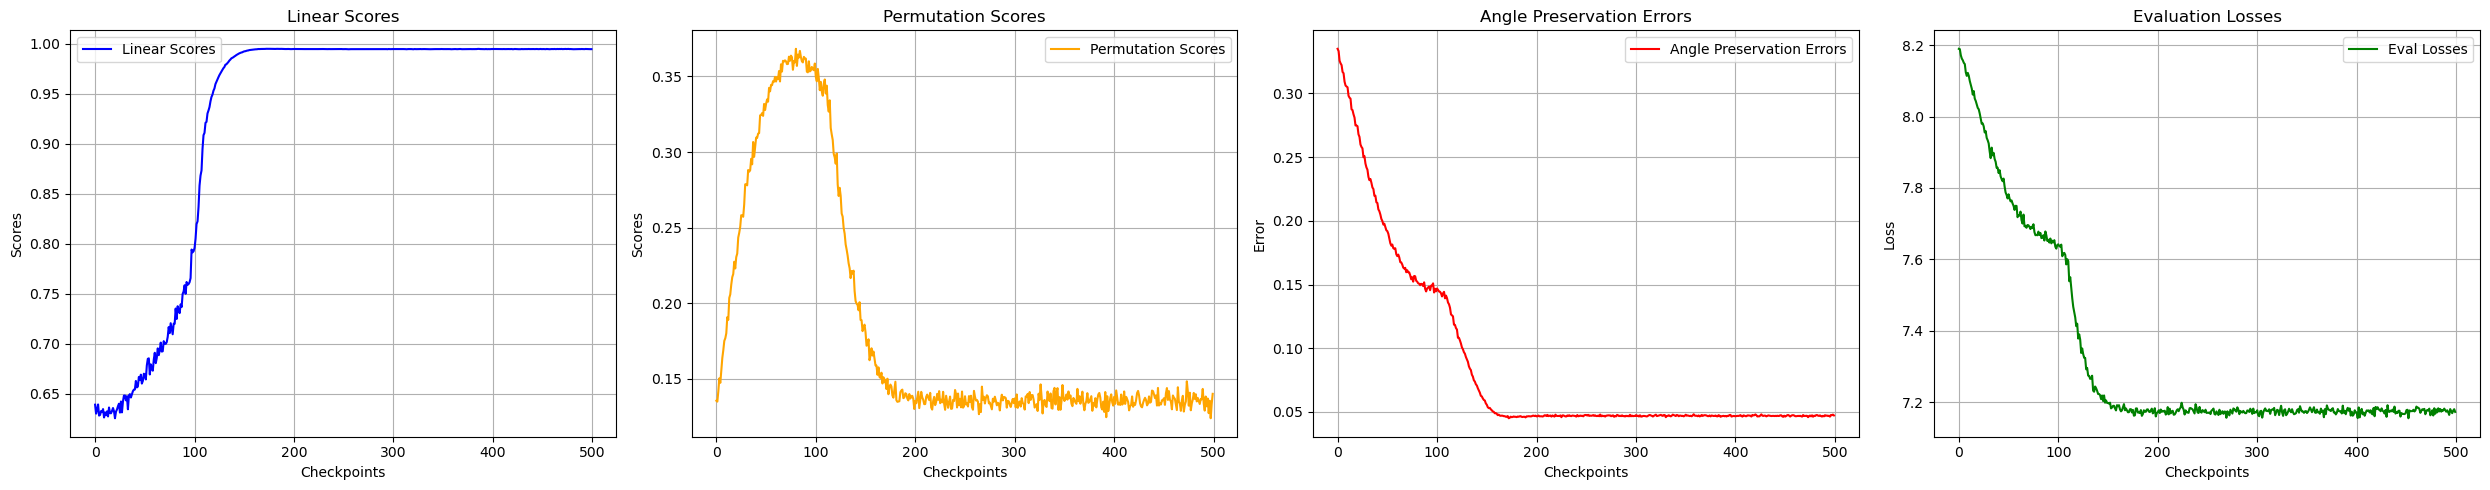

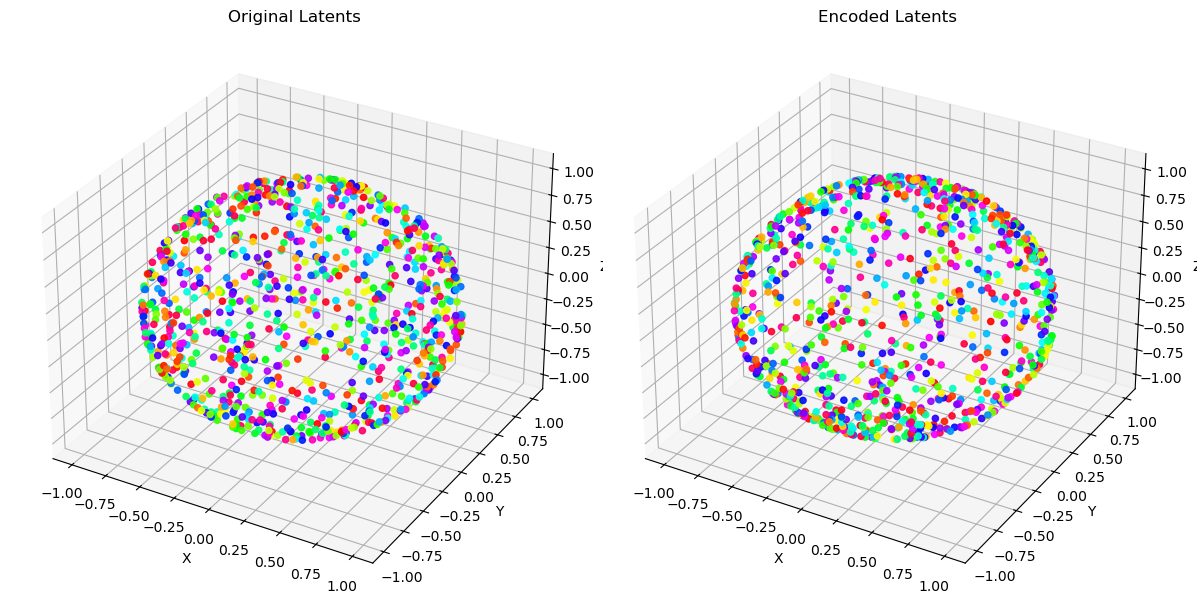

In [25]:
from experiment_utils.linear import perform_linear_experiment

f_linear_constrained = LinearEncoder(5, 3)

h, scores = perform_linear_experiment(
    5, iterations , batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f=f_linear_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [26]:
print(compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed))
print("Training loss", scores['eval_losses'][-1])

7.190587043762207
Training loss 7.17325496673584


Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.780572891235352 Samples processed: 1 linear disentanglement: 0.8630048632621765 permutation disentanglement: 0.38616445660591125 angle_preservation_error: 0.20663435757160187
Loss: 7.756803035736084 Samples processed: 21 linear disentanglement: 0.869548499584198 permutation disentanglement: 0.3955751955509186 angle_preservation_error: 0.20406675338745117
Loss: 7.750967025756836 Samples processed: 41 linear disentanglement: 0.8705838322639465 permutation disentanglement: 0.3879890441894531 angle_preservation_error: 0.204375222325325
Loss: 7.734185218811035 Samples processed: 61 linear disentanglement: 0.8729127049446106 permutation disentanglement: 0.38697633147239685 angle_preservation_error: 0.20100967586040497
Loss: 7.730838298797607 Samples processed: 81 linear disentanglement: 0.8739182353019714 permutation disentanglement: 0.40093159675598145 angle_preservation_error: 0.19730804860591888
Loss: 7.7101054191589355 Samp

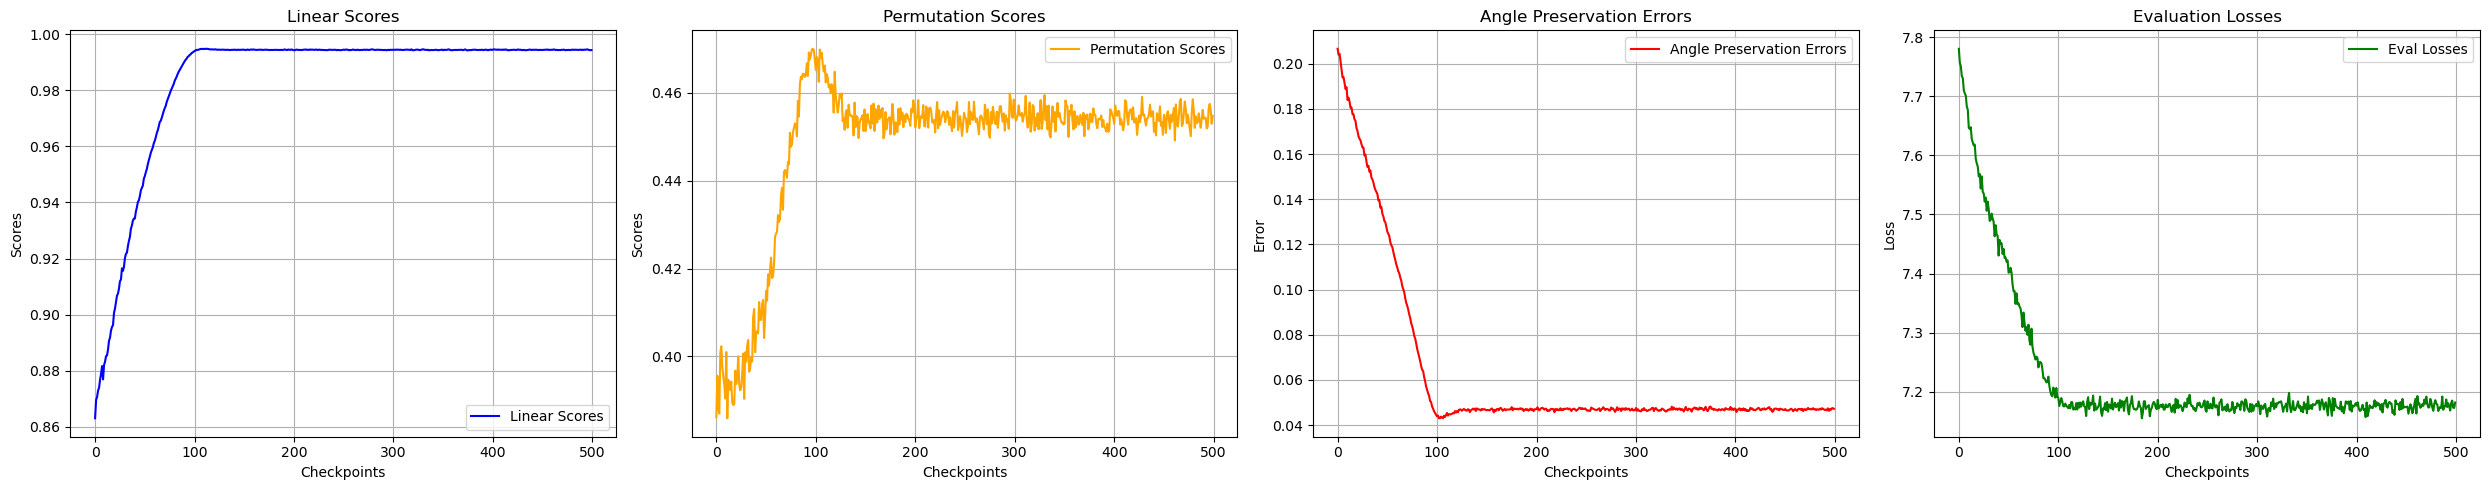

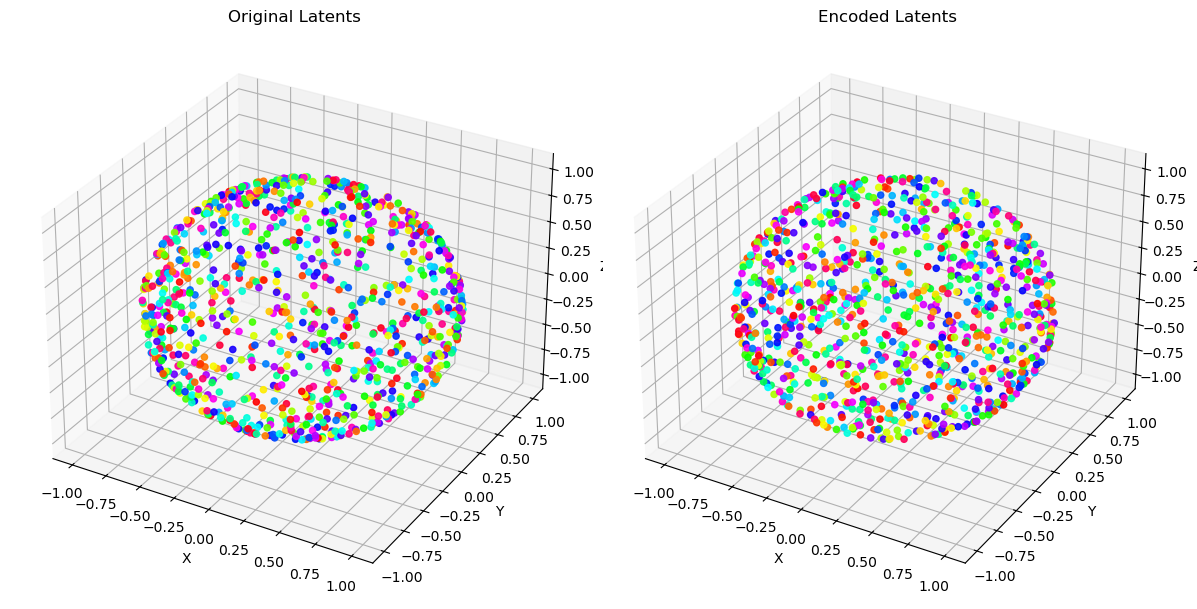

In [27]:
from experiment_utils.linear import perform_linear_experiment

f_linear_constrained = LinearEncoder(6, 3)

h, scores = perform_linear_experiment(
    6, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f=f_linear_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [28]:
print(compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed))
print("Training loss", scores['eval_losses'][-1])

7.194988250732422
Training loss 7.181551933288574


Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.877158164978027 Samples processed: 1 linear disentanglement: 0.7574427127838135 permutation disentanglement: 0.3790872097015381 angle_preservation_error: 0.2647637724876404
Loss: 7.851789474487305 Samples processed: 21 linear disentanglement: 0.7665367126464844 permutation disentanglement: 0.38043785095214844 angle_preservation_error: 0.26128068566322327
Loss: 7.850020408630371 Samples processed: 41 linear disentanglement: 0.7601243853569031 permutation disentanglement: 0.38450416922569275 angle_preservation_error: 0.25710779428482056
Loss: 7.81483268737793 Samples processed: 61 linear disentanglement: 0.7746054530143738 permutation disentanglement: 0.40234604477882385 angle_preservation_error: 0.2511708438396454
Loss: 7.817649841308594 Samples processed: 81 linear disentanglement: 0.7628886103630066 permutation disentanglement: 0.38669881224632263 angle_preservation_error: 0.24871985614299774
Loss: 7.792716979980469 Samp

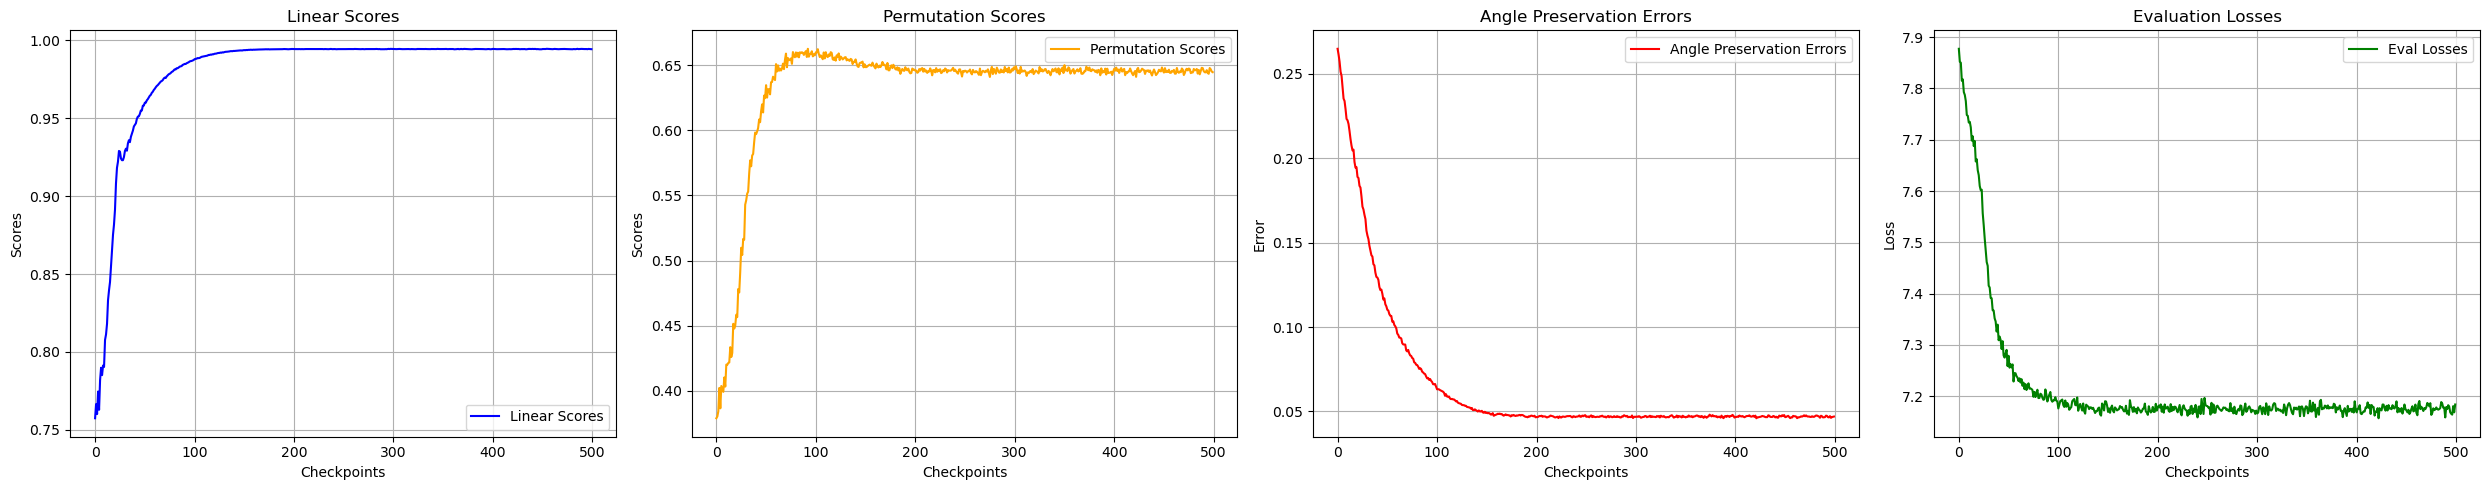

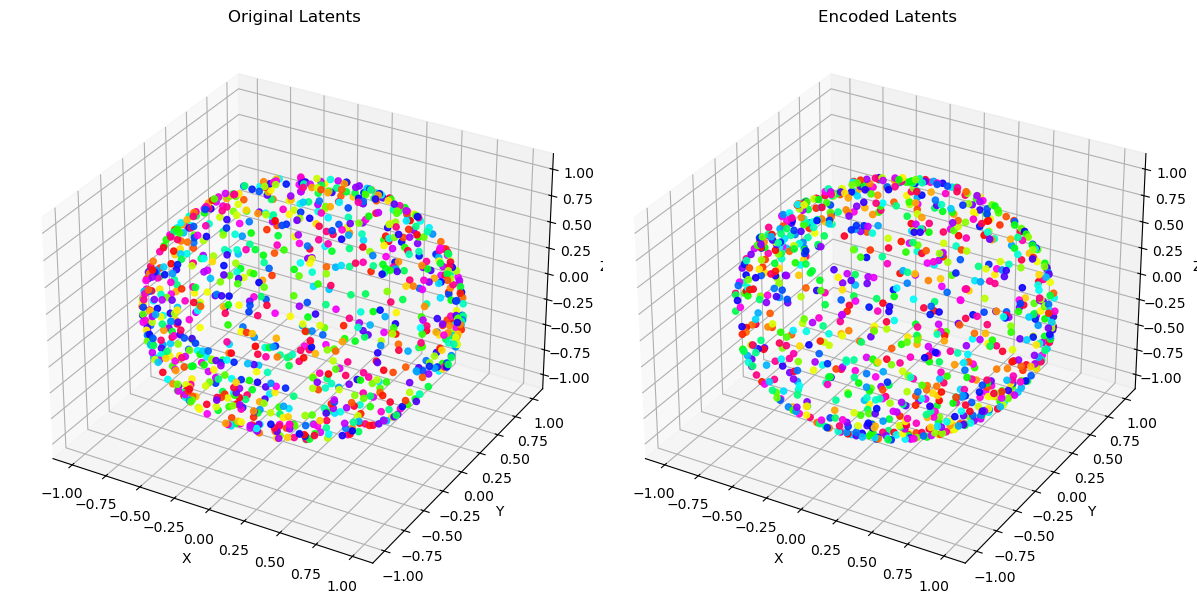

In [30]:
from experiment_utils.linear import perform_linear_experiment

f_linear_constrained = LinearEncoder(7, 3)

h, scores = perform_linear_experiment(
    7, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device, f=f_linear_constrained
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [32]:
print(compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed))
print("Training loss", scores['eval_losses'][-1])

7.201165676116943
Training loss 7.18399715423584


## Spiral generating process

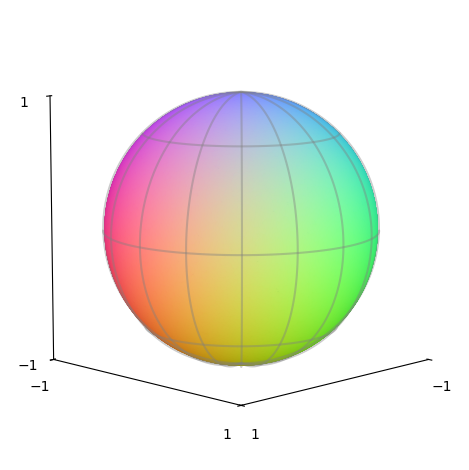

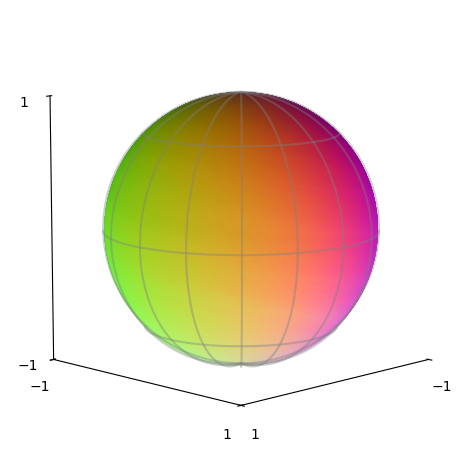

In [27]:
# from visualization_utils.scoring import plot_scores
from visualization_utils.spheres import scatter3d_sphere

from data.generation import SpiralRotation
from encoders import SphericalEncoder

f_spiral = SphericalEncoder(input_dim=3, hidden_dims=[128, 256, 128], output_dim=3)

g_spiral = SpiralRotation(2)

simclr_spiral = SimCLR(
    f_spiral, g_spiral, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_spiral, scores = simclr_spiral.train(batch_size, iterations)

plot_scores(plt, scores)

h_spiral = lambda z: f_spiral(g_spiral(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_spiral(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000).to(device)
z_enc = h_spiral(z).to(device)

fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), h_spiral(z).cpu(), s=10, a=.8)

In [28]:
print("Orthogonal transform loss:", compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed))
print("Training loss", scores['eval_losses'][-1])

Orthogonal transform loss: 7.193449020385742
Training loss 7.186282157897949


## Patched generating process

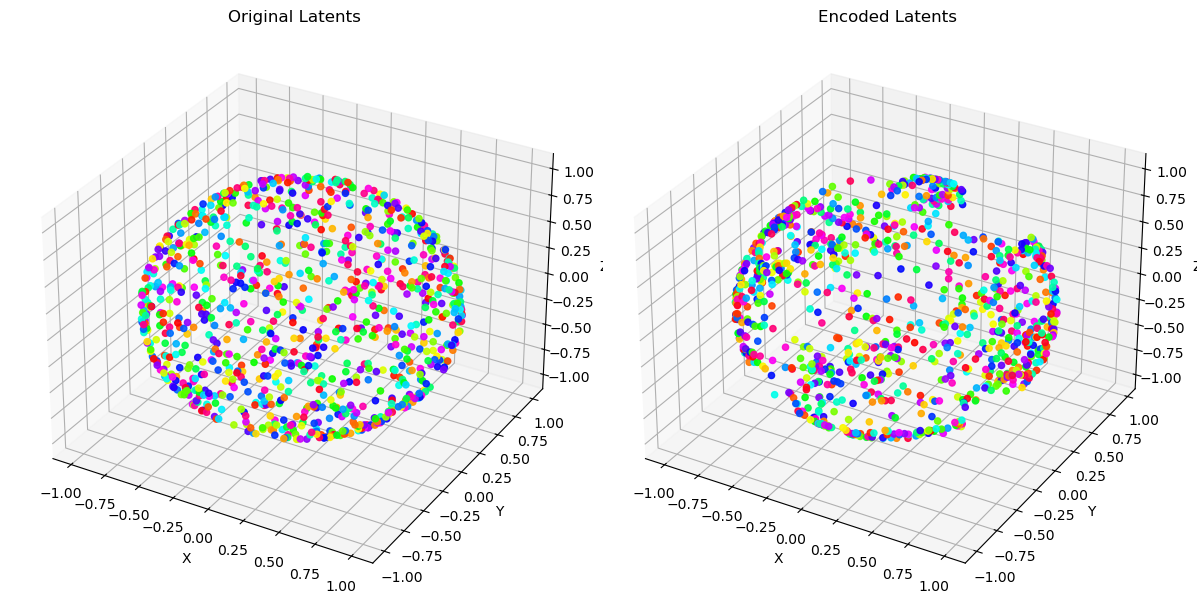

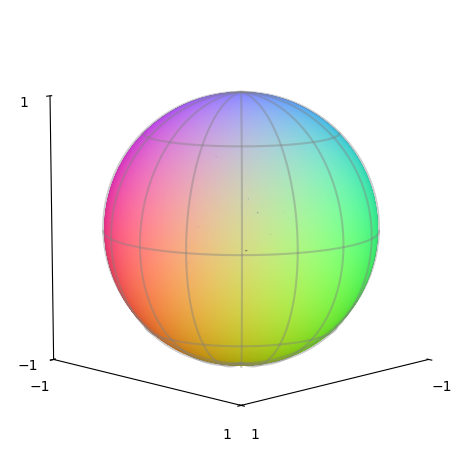

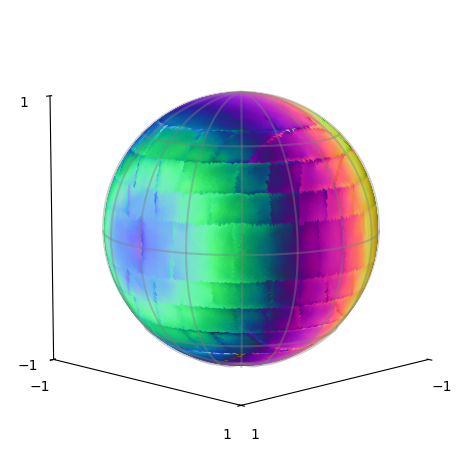

In [17]:
from visualization_utils.spheres import scatter3d_sphere
from visualization_utils.scoring import plot_scores

from data.generation import Patches

from encoders import SphericalEncoder

g_patches = Patches(5, device)
f_patches = SphericalEncoder(input_dim=3, hidden_dims=[128, 256, 128], output_dim=3)

simclr_patches = SimCLR(
    f_patches, g_patches, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_patches, scores = simclr_patches.train(batch_size, iterations)

plot_scores(plt, scores)

h_patches = lambda z: f_patches(g_patches(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_patches(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000).to(device)
z_enc = h_patches(z).to(device)

fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), h_patches(z).cpu(), s=10, a=.8)

In [12]:
print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed))
print("Training loss", scores['eval_losses'][-1])

7.19257116317749
Training loss 6.988463401794434


## Experiment with the invertible MLP as a data generating process

condition number threshold: 1.039983
layer 1/3,  condition number: 1.0182842121142552
layer 2/3,  condition number: 1.0386268837487342
layer 3/3,  condition number: 1.0358627764043027


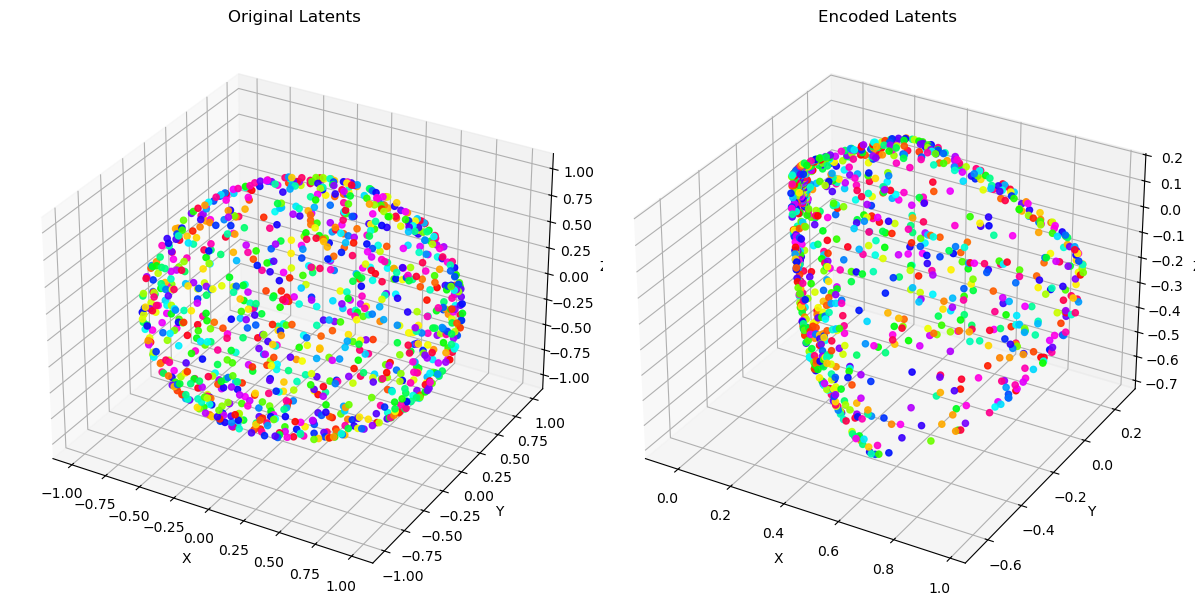

In [18]:
from invertible_network_utils import construct_invertible_mlp

g_mlp = construct_invertible_mlp(
        n=3,
        n_layers=3,
        act_fct='leaky_relu',
        cond_thresh_ratio=0.0,
        n_iter_cond_thresh=25000,
).to(device)

z = full_sphere.uniform(1000).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), g_mlp(z).cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.885261535644531 Samples processed: 1 linear disentanglement: 0.5182787775993347 permutation disentanglement: 0.0434952974319458 angle_preservation_error: 0.22296468913555145
Loss: 7.257866859436035 Samples processed: 21 linear disentanglement: 0.9093161225318909 permutation disentanglement: 0.10368558019399643 angle_preservation_error: 0.10061361640691757
Loss: 7.2102370262146 Samples processed: 41 linear disentanglement: 0.9478705525398254 permutation disentanglement: 0.14063908159732819 angle_preservation_error: 0.0796637237071991
Loss: 7.1948041915893555 Samples processed: 61 linear disentanglement: 0.9637940526008606 permutation disentanglement: 0.16259680688381195 angle_preservation_error: 0.07090651243925095
Loss: 7.200824737548828 Samples processed: 81 linear disentanglement: 0.9703806042671204 permutation disentanglement: 0.1733965277671814 angle_preservation_error: 0.06526265293359756


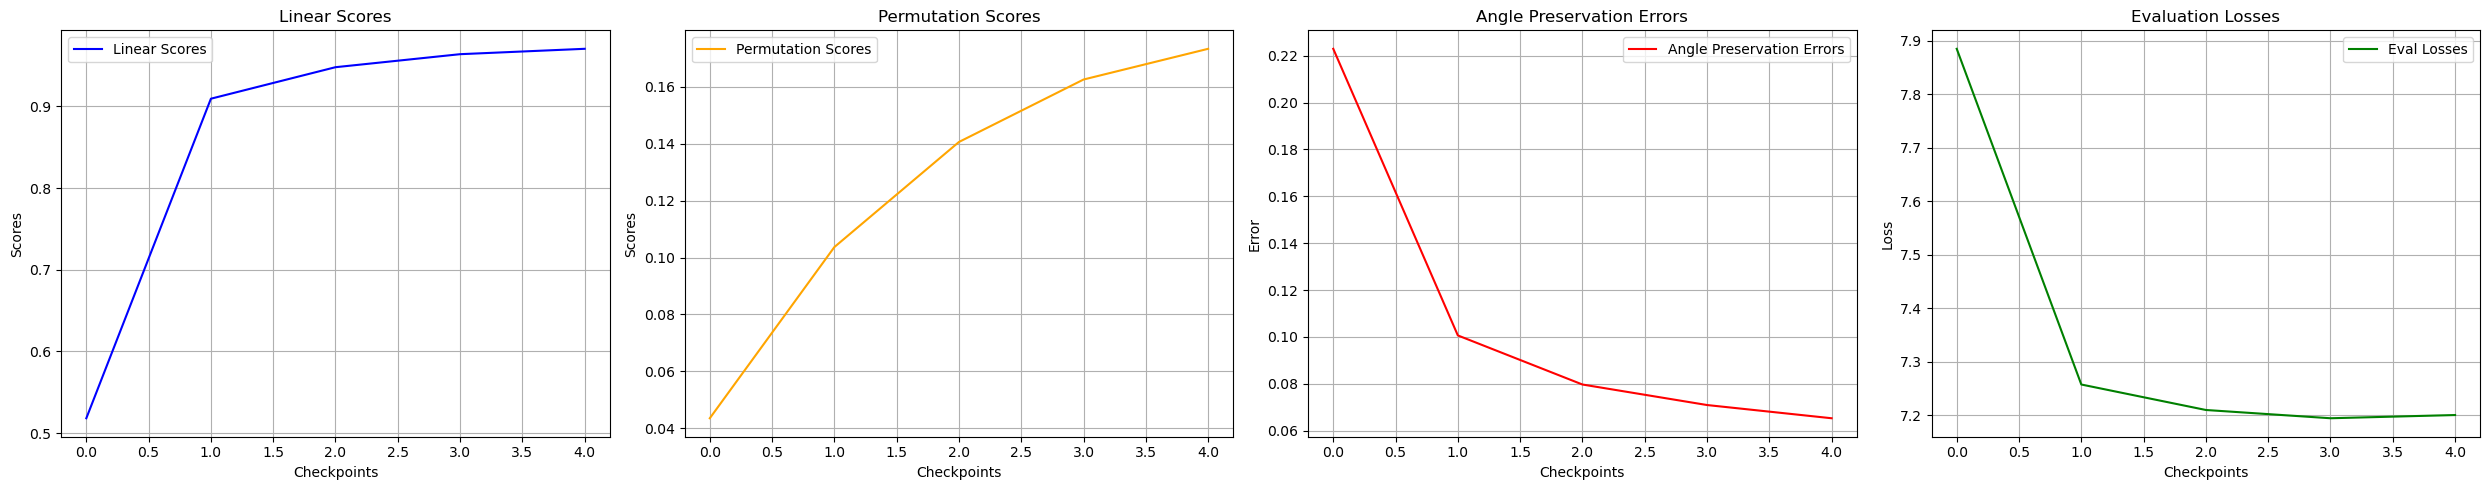

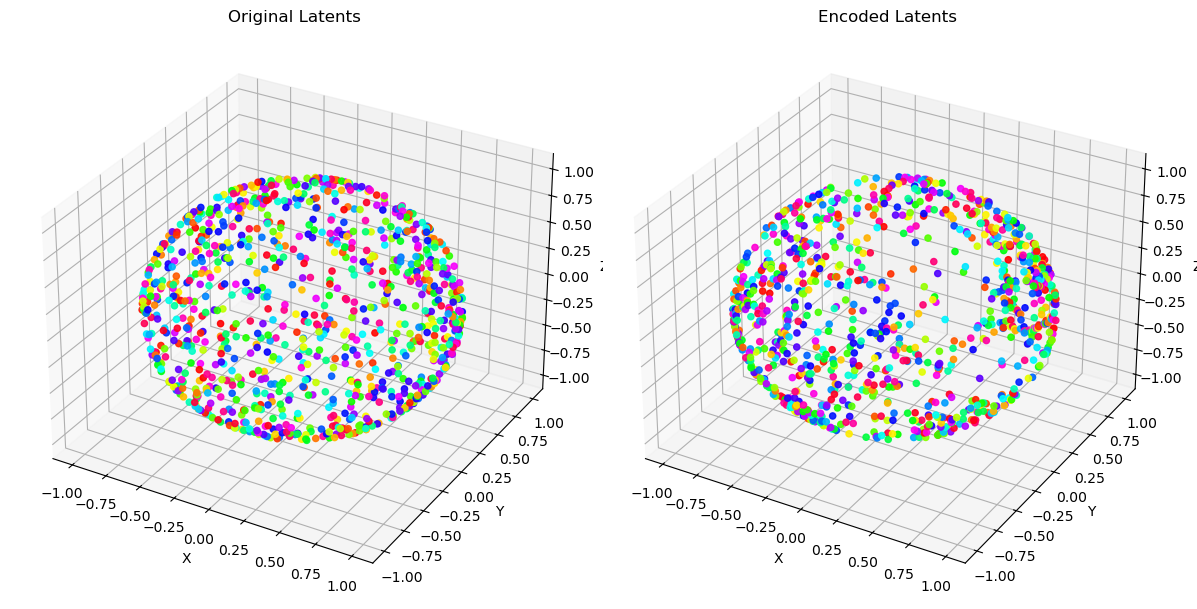

In [25]:
f_mlp = SphericalEncoder(input_dim=3, hidden_dims=[128, 256, 128], output_dim=3).to(device)

simclr_mlp = SimCLR(
    f_mlp, g_mlp, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_mlp, scores = simclr_mlp.train(batch_size, 100)

plot_scores(plt, scores)

h_mlp = lambda latent: f_mlp(g_mlp(latent))

z = full_sphere.uniform(1000).to(device)
z_enc = h_mlp(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [21]:
print("Orhtogonal loss:", compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed))
print("Training loss", scores['eval_losses'][-1])

Orhtogonal loss: 7.202197551727295
Training loss 6.838132858276367


In [35]:
min([compute_orthogonal_transformation_loss(sample_joint=sample_pair_fixed, sample_marginal=sample_uniform_fixed) for _ in range(100)])

tensor(7.4834)

## Next

- Run it with a correct model (Cross-Entropy with a correct normalizer)